In [19]:
from gurobipy import *
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Optimization

In [20]:
# Flight time matrix
tau = [[0, 6.06667], [6.06667, 0]]
tau = np.array(tau) / 5
tau = np.ceil(tau)

# SOC levels drop matrix
kappa = [[0, 1], [1, 0]]

# Charging Time matrix
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [21]:



# Constants
T = int(1440 / 5)
K = 8
V = [0, 1]


T = 2 * T

f_values = np.zeros((T, 2, 2))
data = pd.read_csv('../input/schedule.csv')
LAX_DTLA = data[data['od'] == 'LAX_DTLA']
DTLA_LAX = data[data['od'] == 'DTLA_LAX']
# Create the list of lists
LAX_DTLA = [[1 if i in LAX_DTLA['schedule'].tolist() else 0] for i in range(1440)]
DTLA_LAX = [[1 if i in DTLA_LAX['schedule'].tolist() else 0] for i in range(1440)]

# Reshape the array
new_array_LAX_DTLA = np.array(LAX_DTLA).reshape((288, 5))
new_array_DTLA_LAX = np.array(DTLA_LAX).reshape((288, 5))
# Convert back to list
new_array_LAX_DTLA = new_array_LAX_DTLA.tolist()
new_array_DTLA_LAX = new_array_DTLA_LAX.tolist()
# Add elements within each cell
new_array_LAX_DTLA_sum = np.sum(new_array_LAX_DTLA, axis=1)
new_array_DTLA_LAX_sum = np.sum(new_array_DTLA_LAX, axis=1)

LAX_DTLA = new_array_LAX_DTLA_sum
DTLA_LAX = new_array_DTLA_LAX_sum



In [22]:
LAX_DTLA1 = np.concatenate((LAX_DTLA[144:], LAX_DTLA, LAX_DTLA[:144]))
DTLA_LAX1 = np.concatenate((DTLA_LAX[144:], DTLA_LAX, DTLA_LAX[144:]))

In [23]:
for t in range(T - 1):
    f_values[t][0][1] = LAX_DTLA1[t] # get the first (and only) item of the inner list
    f_values[t][1][0] = DTLA_LAX1[t] # get the first (and only) item of the inner list

In [24]:
# f_values[T-1][0][1] = LAX_DTLA[0]
# f_values[T-1][1][0] = DTLA_LAX[0]
# Create a new model
m = Model("Vertiport_Aircraft_Routing")

# Create variables
ni = m.addVars(((t, i, k) for t in range(T+1) for i in V for k in range(K+1)), vtype=GRB.INTEGER, name="n")
uij = m.addVars(((t, i, j, k) for t in range(T+1) for i in V for j in V for k in range(K+1) if i != j), vtype=GRB.INTEGER, name="u")
cijk = m.addVars(((t, i, x, y) for t in range(T+1) for i in V for x in range(K+1) for y in range(K+1) if x < y), vtype=GRB.INTEGER, name="c")

# Define the objective
m.setObjective(ni.sum(0, '*', '*') + uij.sum(0, '*', '*', '*') + cijk.sum(0, '*', '*', '*'), GRB.MINIMIZE)


# Dynamic equation
for i in V:
    for k in range(K+1):
        for t in range(T+1):
            if t > 0:
                m.addConstr(
                    ni[t, i, k] == ni[t-1, i, k] + 
                    quicksum(uij[t-tau[j][i], j, i, k+kappa[j][i]] for j in V if j != i and t-1-tau[j][i] >= 0 and k+kappa[j][i] <= K) -
                    quicksum(uij[t, i, j, k] for j in V if j != i) +
                    quicksum(cijk[t-sum(gamma[x:k]), i, x, k] for x in range(k) if t-sum(gamma[x:k]) >= 0) -
                    quicksum(cijk[t, i, k, y] for y in range(k+1, K+1))
                )

# # Constraints
# # Each time step, total number of aircraft is the same
# for t in range(1, T+1):
#     m.addConstr(ni.sum(t, '*', '*') + uij.sum(t, '*', '*', '*') + cijk.sum(t, '*', '*', '*') == 
#                 ni.sum(t-1, '*', '*') + uij.sum(t-1, '*', '*', '*') + cijk.sum(t-1, '*', '*', '*'))

# # When it starts, we only fly aircraft with full charging status
# for k in range(K):
#     m.addConstr(uij[0, 1, 0, k] == 0)
#     m.addConstr(uij[0, 0, 1, k] == 0)
# # If anything idle in the beginning, it will be full charged
# for k in range(K):
#     m.addConstr(ni[0,0,k] == 0)
#     m.addConstr(ni[0,1,k] == 0)
    
# Stationary Constraint
for k in range(K+1):
    for i in V:
        m.addConstr(ni[144, i, k] == ni[144 + 288, i, k])
        m.addConstr(uij[144, i, 1-i, k] == uij[144 + 288, i, 1-i, k])
        
for x in range(K+1):
    for y in range(K+1):
        for i in V:
            if (x < y):
                m.addConstr(cijk[144, i, x, y] == cijk[144 + 288, i, x, y])
        

# # nothing is charging at the first timestep
# for x in range(K+1):
#     for y in range(K+1):
#         if x < y:
#             m.addConstr(cijk[0, 1, x, y] == 0)
#             m.addConstr(cijk[0, 0, x, y] == 0)

# m.addConstr(ni.sum(0, '*', '*') + uij.sum(0, '*', '*', '*') + cijk.sum(0, '*', '*', '*') == 
#            ni.sum(T, '*', '*') + uij.sum(T, '*', '*', '*') + cijk.sum(T, '*', '*', '*'))

# # Too strict for the stationarity
# for k in range(K+1):
#    m.addConstr(ni[0, 1, k] == ni[T, 1, k])
#    m.addConstr(ni[0, 0, k] == ni[T, 0, k])


# # Upper Bound for uij
# for t in range(1, T+1):
#     for i in V:
#         for k in range(K+1):
#             m.addConstr(uij[t, i, 1 - i, k] <= ni[t, i, k] + quicksum(uij[t-tau[j][i], j, i, k+kappa[j][i]] for j in V if j != i and t-1-tau[j][i] >= 0 and k+kappa[j][i] <= K)
#                         + quicksum(cijk[t-sum(gamma[x:k]), i, x, k] for x in range(k) if t-sum(gamma[x:k]) >= 0)) 

# # Upper Bound for cijk
# for t in range(1, T+1):
#     for i in V:
#         for k in range(K+1):
#             m.addConstr(quicksum(cijk[t, i, k, y] for y in range(k+1, K+1)) <= ni[t, i, k] + quicksum(uij[t-tau[j][i], j, i, k+kappa[j][i]] for j in V if j != i and t-1-tau[j][i] >= 0 and k+kappa[j][i] <= K)
#                         + quicksum(cijk[t-sum(gamma[x:k]), i, x, k] for x in range(k) if t-sum(gamma[x:k]) >= 0) - uij[t, i, 1 - i, k]) 

# The flight schedule must be satisfied.
for j in V:
    for i in V:
        if i != j:
            for t in range(T):
                m.addConstr(uij.sum(t, i, j, '*') >= f_values[t][i][j])

# Can't fly when SOC = 0
for i in V:
    for j in V:
        for t in range(T+1):
            if i != j:
                m.addConstr(uij[t, i, j, 0] == 0)


          



# Integrate new variables
m.update()

# Solve model
m.optimize()
# Redirect stdout to a file
# sys.stdout = open('output.txt', 'w')

# if m.status == GRB.Status.INFEASIBLE:
#     print('The model is infeasible; computing IIS')
#     m.computeIIS()
#     m.write("model.ilp")
#     m.feasRelaxS(0, False, False, True) # calculate relaxed solution
#     m.optimize()

# Print results
for v in m.getVars():
    if v.x > 0:  # Print only non-zero variables for clarity
        print('{} = {}'.format(v.varName, v.x))

print('Total Fleet Size:', m.objVal)

# Close the output file
# sys.stdout.close()


# Open a file for writing
with open('../output/variable_values.txt', 'w') as file:
    # Redirect standard output to the file
    old_stdout = sys.stdout
    sys.stdout = file
    print("results")
    # Check variable values and write them to the file
    for v in m.getVars():
        if v.x > 0:  # Print only non-zero variables for clarity
            print('{} = {}'.format(v.varName, v.x))

    # Restore standard output
    sys.stdout = old_stdout




Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 12782 rows, 62316 columns and 134378 nonzeros
Model fingerprint: 0x04003b03
Variable types: 0 continuous, 62316 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 1519 rows and 2508 columns
Presolve time: 0.12s
Presolved: 11263 rows, 59808 columns, 127980 nonzeros
Variable types: 0 continuous, 59808 integer (6 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30768    2.3023244e+01   0.000000e+00   3.430686e+03      5s
   48767    1.8982731e+01   0.000000e+00   2.598631e+03     10s
   66695    1.

# Testing

In [ ]:
results = pd.read_table('../output/variable_values.txt')
n = results[results["results"].str.contains("n")]
u = results[results["results"].str.contains("u")]
c = results[results["results"].str.contains("c")]
varn = n['results'].str.split('=').apply(lambda x: x[0])
valn = n['results'].str.split('=').apply(lambda x: x[1])
t = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
k = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = valn
specificn = pd.DataFrame(np.array([t,i,k,amount]).T).reset_index(drop=True)
specificn.columns = ['t','i', 'k', 'amount']
specificn['name'] = 'n'

varu = u['results'].str.split('=').apply(lambda x: x[0])
valu = u['results'].str.split('=').apply(lambda x: x[1])
t = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
k = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valu
specificu = pd.DataFrame(np.array([t,i,j,k,amount]).T).reset_index(drop=True)
specificu.columns = ['t','i', 'j', 'k', 'amount']
specificu['name'] = 'u'

varc = c['results'].str.split('=').apply(lambda x: x[0])
valc = c['results'].str.split('=').apply(lambda x: x[1])
t = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
x = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
y = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valc
specificc = pd.DataFrame(np.array([t,i,x,y,amount]).T).reset_index(drop=True)
specificc.columns = ['t','i', 'x', 'y', 'amount']
specificc['name'] = 'c'
specificn['amount'] = specificn['amount'].astype(float)
specificu['amount'] = specificu['amount'].astype(float)
specificc['amount'] = specificc['amount'].astype(float)


In [ ]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

In [ ]:
specificu01 = specificu01.groupby('t').sum().reset_index()
specificu10 = specificu10.groupby('t').sum().reset_index()


In [ ]:
specificu01

,t,i,j,k,amount,name
0,0,0,1,1,2.0,u
1,1,0,2,9,2.0,uu
2,2,0,1,6,1.0,u
3,3,0,1,7,1.0,u
4,4,0,2,12,2.0,uu
...,...,...,...,...,...,...
543,570,0,2,10,3.0,uu
544,571,0,1,2,1.0,u
545,572,0,1,2,2.0,u
546,573,0,1,1,2.0,u


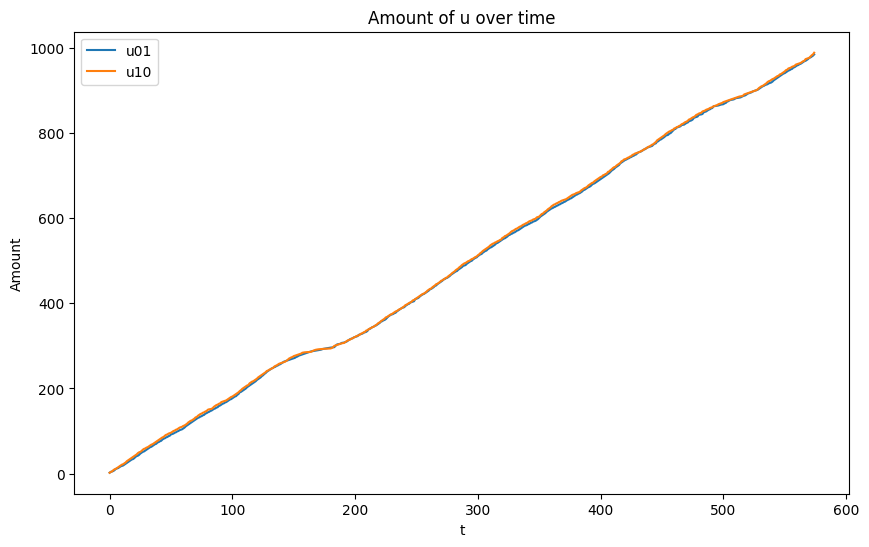

In [ ]:
# Data from specificu
specificu_t01 = list(specificu01['t'])
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t'])
specificu_amount10 = list(specificu10['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(specificu_t01, np.cumsum(specificu_amount01), label='u01')
plt.plot(specificu_t10, np.cumsum(specificu_amount10), label='u10')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('Amount of u over time')
plt.legend()
plt.show()


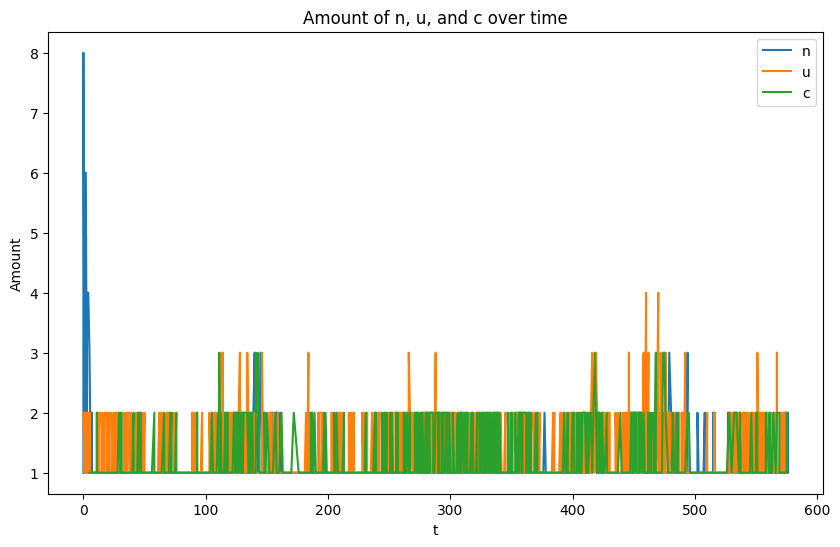

In [ ]:


# Data from specificn
specificn_t = list(specificn['t'])
specificn_amount = list(specificn['amount'])

# Data from specificu
specificu_t = list(specificu['t'])
specificu_amount = list(specificu['amount'])

# Data from specificc
specificc_t = list(specificc['t'])
specificc_amount = list(specificc['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(specificn_t, specificn_amount, label='n')
plt.plot(specificu_t, specificu_amount, label='u')
plt.plot(specificc_t, specificc_amount, label='c')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('Amount of n, u, and c over time')
plt.legend()
plt.show()


In [ ]:


# Data from specificn
specificn_t = list(specificn['t'])
specificn_amount = list(specificn['amount'])

# Data from specificu
specificu_t = list(specificu['t'])
specificu_amount = list(specificu['amount'])

# Data from specificc
specificc_t = list(specificc['t'])
specificc_amount = list(specificc['amount'])

In [ ]:
specificn

,t,i,k,amount,name
0,0,0,8,5.0,n
1,0,1,8,7.0,n
2,1,0,8,2.0,n
3,1,1,8,6.0,n
4,2,0,8,1.0,n
...,...,...,...,...,...
73,269,1,1,1.0,n
74,278,1,3,1.0,n
75,282,1,0,2.0,n
76,284,0,2,1.0,n


In [ ]:
specificu

,t,i,j,k,amount,name
0,0,0,1,8,1.0,u
1,0,1,0,8,1.0,u
2,1,0,1,8,3.0,u
3,1,1,0,8,1.0,u
4,2,0,1,8,1.0,u
...,...,...,...,...,...,...
792,286,1,0,2,4.0,u
793,286,1,0,3,2.0,u
794,288,0,1,1,4.0,u
795,288,0,1,2,2.0,u


In [ ]:
specificc

,t,i,x,y,amount,name
0,3,1,7,8,1.0,c
1,5,0,6,8,1.0,c
2,9,0,4,6,1.0,c
3,11,0,3,8,1.0,c
4,11,1,6,7,1.0,c
...,...,...,...,...,...,...
522,285,0,2,3,1.0,c
523,286,1,0,3,2.0,c
524,287,0,3,4,1.0,c
525,287,1,0,2,1.0,c
